# Sentiment Analysis of Reddit Data

### Does mood fluctuate throughout the day?

My strategy for trying to understand this question is to calculate sentiment scores from posts in the r/depression subreddit. I thought that the best way to tease out any releationship would be to analyze people who are at the more extreme ends of the mood spectrum. Each post on reddit is then time stamped, so I will be able to perform a statistical analysis on the sentiment scores throughout the day. After I gather Reddit post data I will feed it through a sentiment analysis model, and my output will be scores of negative, neutral, and positive sentiment scores.

### Literature

Sentiment analysis is an NLP (Natural Language Processing) technique used generally to determine if human speech is positive, negative, or neutral. Oftentimes sentiment analysis wil use a machine learning trained model to determine the sentiment. Many of the more impactful papers in this field began to appear in the early 2000's, but work was underway in this topic as early as the 1950's. One of the most impactful papers with 12,000 citations is ["opinion mining and sentiment analysis"](https://www.cs.cornell.edu/home/llee/omsa/omsa.pdf), 2008 (Bo Pang, Lillian Lee) where they describe many ML and tradititional classification technique for sentiment analysis. Many others have analyzed social media data for sentiment, my approach is novel because as far as I can tell no one else has tried to use sentiment analysis to investigate mood fluctuations. 

## Gathering Data

To gather the data I will be using in this analysis I used the Reddit API. When using the API you can specify which headers to grab from each post. 

I choose:

**Title** &rarr; Title of the Reddit post

**selftext** &rarr; Body of the reddit post

**created_utc** &rarr; Time the reddit post was created in seconds since unix epoch

**num_comments** &rarr; Number of comments on reddit post

**upvote_ratio** &rarr; Upvotes divided by down votes

**ups** &rarr; Number of upvotes

**downs** &rarr; Number of downvotes

**id** &rarr; Post id

**kind** &rarr; Another identifier of the reddit post


### Authentication for Redddit API

NOTE: All keys and identifiers have been replaced with "xxx"

### Data gathering from reddit api, saving as a data table

## Cleaning the Data

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import datetime
import pytz
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anthony/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/anthony/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

The original text data when pulling from the reddit API had both emojis and non ascii characters. The code chunk below cleans all the reddit posts to only contain ascii characters. Luckily in this data set I did not have to worry about missing data values because I pulled this from the Reddit API, and reddit ensures all posts have data for every header.

In [3]:
posts_df = pd.read_csv("RedditData.csv")

# Keeps only ascii characters
def clean_txt(row):
    return row.encode('ascii', 'ignore').decode('ascii')

posts_df["cleaned_text"] = posts_df["selftext"].apply(lambda x: clean_txt(x))


Next I wanted to make a word cloud so that I could get an initial sense of what the sentiment in the posts overall might be. To prepare I needed to tokanize and then clean the post data even further using the nltk package. I first removed stop words from the data such as “the”, “a”, “an”, “in”. Next I applied the nltk lemmatization function to the text data which converts similar forms of a word into one word. 

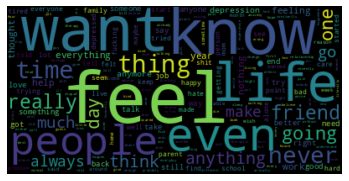

In [4]:
# Cleans text to be used in word cloud
def wordcloud_clean(row):
    row = contractions.fix(row)

    tokens = word_tokenize(row)
    tokens = [w.lower() for w in tokens]
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    mystring = ' '.join(map(str, words))

    return mystring

posts_df["wordcloud_txt"] = posts_df["cleaned_text"].apply(lambda x: wordcloud_clean(x))

text = ""

for index, row in posts_df.iterrows():
    text += row['wordcloud_txt']

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
posts_df.to_csv("RedditDataCleaned.csv")

Next I need to convert the time I got from the reddit API which is seconds since unix epoch into US central time so that I can split up reddit posts based on the time of day.

In [5]:
def convert_time(row):
        time = datetime.datetime.fromtimestamp(row)
        time = time.astimezone(pytz.timezone('US/Central')).strftime('%H')
        time = int(time)
        return time

posts_df["time"] = posts_df["created_utc"].apply(lambda x: convert_time(x))

posts_df.head()

,Unnamed: 0,title,selftext,created_utc,num_comments,upvote_ratio,ups,downs,id,kind,cleaned_text,wordcloud_txt,time
0,0,Mood changes,I was diagnosed with major depressive disorder...,1.654825e+09,0,1.0,1,0,v8wabq,t3,I was diagnosed with major depressive disorder...,diagnosed major depressive disorder december l...,20
1,1,I just want to be normal again.,"I’ve been going through a tough time lately, t...",1.654824e+09,1,1.0,1,0,v8w68f,t3,"Ive been going through a tough time lately, th...","going tough time lately , ocd mine completely ...",20
2,2,I can't leave my room. Advice?,I don't think I have depression? I don't wanna...,1.654824e+09,0,1.0,1,0,v8w01i,t3,I don't think I have depression? I don't wanna...,think depression ? want self-diagnose . sure p...,20
3,3,I hate my family,"Hi, I don’t know who to talk to but I’ve been ...",1.654824e+09,0,1.0,1,0,v8vzfk,t3,"Hi, I dont know who to talk to but Ive been ha...","hi , know talk bad life . ever since high scho...",20
4,4,I've had a very bad day today,"Lost my keys and card, being left out by group...",1.654823e+09,0,1.0,2,0,v8vw9r,t3,"Lost my keys and card, being left out by group...","lost key card , left group girl college , thre...",20


## Sentiment Analysis

To perform the sentiment analysis I am using the VADER (Valence Aware Dictionary for Sentiment Reasoning) model from the nltk package. The model outputs a dictionary of negative, neutral, and positive sentiment scores as well as a composite score. After running the model on the Reddit data I then converted the output dictionary to four columns in the data frame. I also worte a function to bin all of the posts into 4 generalized time of day (Morning, Afternoon, Evening, Night).

In [6]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

posts_df['scores'] = posts_df['cleaned_text'].apply(lambda x: sid.polarity_scores(x))

posts_df['compound']  = posts_df['scores'].apply(lambda score_dict: score_dict['compound'])

posts_df['neg']  = posts_df['scores'].apply(lambda score_dict: score_dict['neg'])

posts_df['neu']  = posts_df['scores'].apply(lambda score_dict: score_dict['neu'])

posts_df['pos']  = posts_df['scores'].apply(lambda score_dict: score_dict['pos'])

def sentiment(row):
    if row >=.2 and row < .8:
        return 'pos'
    elif row >= .8:
        return 'strong_pos'
    elif row <= -.2 and row > -.8:
        return 'neg'
    elif row <= -.8:
        return 'strong_neg'
    else:
        return 'neu'

def section_day(row):
    if row >= 6 and row <= 11:
        return "Morning"
    elif row >= 12 and row <= 17:
        return "Afternoon"
    elif row >= 18 and row <= 23:
        return "Evening"
    else:
        return "Night"
    
posts_df['comp_score'] = posts_df['compound'].apply(lambda x: sentiment(x))
posts_df['Section_of_Day'] = posts_df['time'].apply(lambda x: section_day(x))

posts_df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/anthony/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Unnamed: 0,title,selftext,created_utc,num_comments,upvote_ratio,ups,downs,id,kind,cleaned_text,wordcloud_txt,time,scores,compound,neg,neu,pos,comp_score,Section_of_Day
0,0,Mood changes,I was diagnosed with major depressive disorder...,1.654825e+09,0,1.0,1,0,v8wabq,t3,I was diagnosed with major depressive disorder...,diagnosed major depressive disorder december l...,20,"{'neg': 0.108, 'neu': 0.777, 'pos': 0.115, 'co...",0.3818,0.108,0.777,0.115,pos,Evening
1,1,I just want to be normal again.,"I’ve been going through a tough time lately, t...",1.654824e+09,1,1.0,1,0,v8w68f,t3,"Ive been going through a tough time lately, th...","going tough time lately , ocd mine completely ...",20,"{'neg': 0.062, 'neu': 0.863, 'pos': 0.074, 'co...",0.1635,0.062,0.863,0.074,neu,Evening
2,2,I can't leave my room. Advice?,I don't think I have depression? I don't wanna...,1.654824e+09,0,1.0,1,0,v8w01i,t3,I don't think I have depression? I don't wanna...,think depression ? want self-diagnose . sure p...,20,"{'neg': 0.138, 'neu': 0.695, 'pos': 0.166, 'co...",0.9471,0.138,0.695,0.166,strong_pos,Evening
3,3,I hate my family,"Hi, I don’t know who to talk to but I’ve been ...",1.654824e+09,0,1.0,1,0,v8vzfk,t3,"Hi, I dont know who to talk to but Ive been ha...","hi , know talk bad life . ever since high scho...",20,"{'neg': 0.264, 'neu': 0.666, 'pos': 0.07, 'com...",-0.9960,0.264,0.666,0.070,strong_neg,Evening
4,4,I've had a very bad day today,"Lost my keys and card, being left out by group...",1.654823e+09,0,1.0,2,0,v8vw9r,t3,"Lost my keys and card, being left out by group...","lost key card , left group girl college , thre...",20,"{'neg': 0.078, 'neu': 0.922, 'pos': 0.0, 'comp...",-0.3182,0.078,0.922,0.000,neg,Evening


## Results

The first plot below is a violin plot with an hour of the day on the x axis and the compound sentiment score on the Y axis. I have also highlighted the medians with the blue points and lines. My interperation of this graph is that within each hour the sentiment scores seem to have a bimodal distribution with the scores clustered around the top or low end. The median fluctuates with the max median at 12 am and the min median at 8 am. Overall there are no clear or consistent trends in the medians.

0 = 0.0149
1 = -0.7943
2 = -0.8116
3 = -0.6602
4 = -0.44830000000000003
5 = -0.3645
6 = -0.659
7 = -0.7374499999999999
8 = -0.8416
9 = -0.7851
10 = -0.1761
11 = -0.6177
12 = -0.5609999999999999
13 = -0.816
14 = -0.6804
15 = -0.5476
16 = -0.8663000000000001
17 = -0.6959
18 = -0.7032
19 = -0.5305
20 = -0.41385
21 = -0.6235999999999999
22 = -0.58605
23 = -0.5379


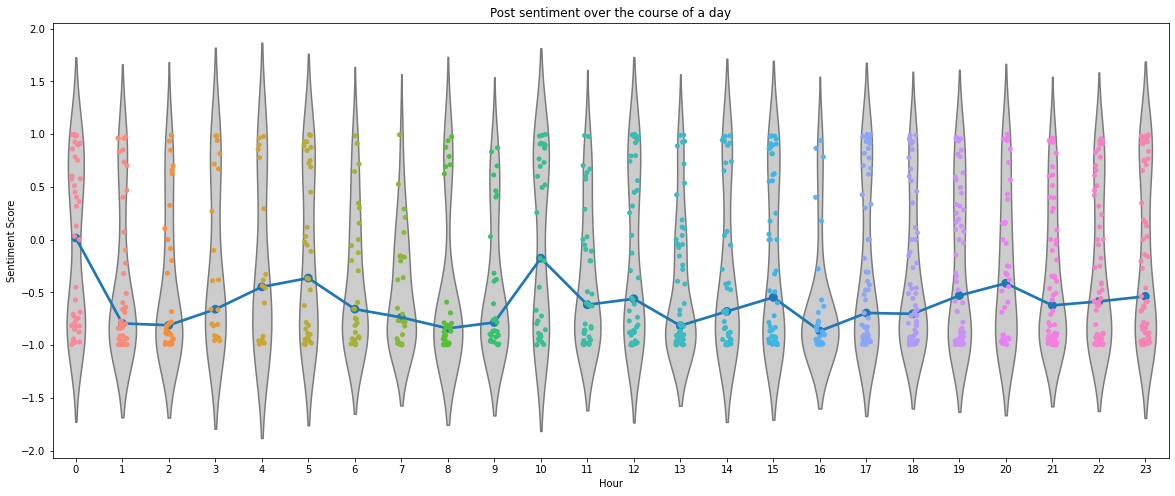

In [14]:
plt.figure(figsize = (20,8))

ax = sns.violinplot(x="time", y="compound", data=posts_df,
                    inner=None, color=".8")

ax = sns.pointplot(x="time", y="compound", data=posts_df, ci = None, estimator=np.median)

ax = sns.stripplot(x="time", y="compound", data=posts_df, jitter = True)

ax.set( xlabel = "Hour", ylabel = "Sentiment Score", title='Post sentiment over the course of a day')

for x in range(24):
   
    print(str(x) + " = " + str(np.median(posts_df[posts_df["time"] == x]["compound"])))

The next plot is similar to the last plot except I have split the data into four general time regions of the day to see if there are any broader trends.

-0.7464
-0.743
-0.5843
-0.642


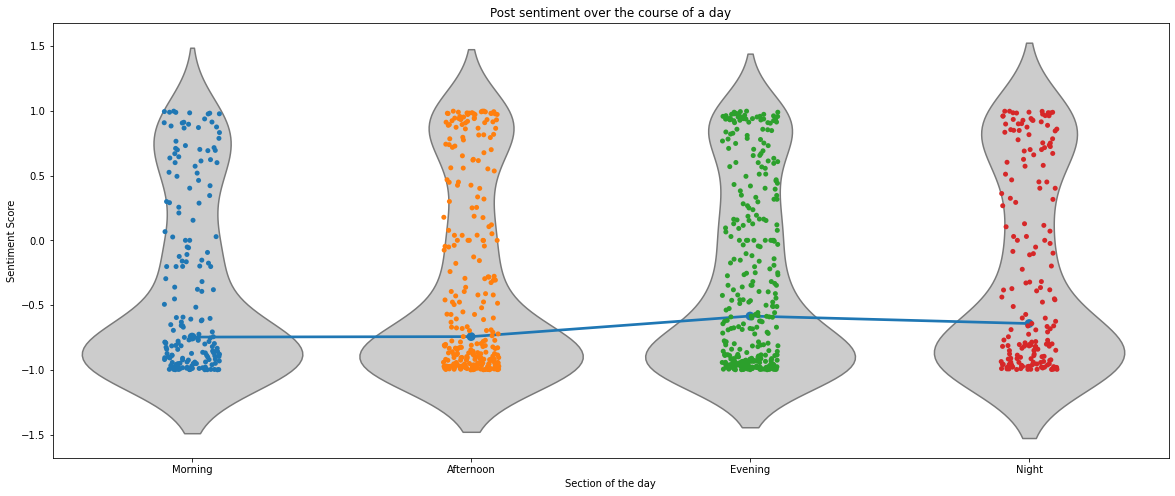

In [17]:
plt.figure(figsize = (20,8))

ax = sns.violinplot(x="Section_of_Day", y="compound", data=posts_df, order = 
                   ["Morning", "Afternoon", "Evening", "Night"],
                    inner=None, color=".8")

ax = sns.pointplot(x="Section_of_Day", y="compound", data=posts_df, ci = None, estimator=np.median, order = 
                   ["Morning", "Afternoon", "Evening", "Night"])

ax = sns.stripplot(x="Section_of_Day", y="compound", data=posts_df, order = 
                   ["Morning", "Afternoon", "Evening", "Night"], jitter = True)

ax.set(xlabel = "Section of the day", ylabel = "Sentiment Score", title='Post sentiment over the course of a day')

morning_median = np.median(posts_df[posts_df["Section_of_Day"] == "Morning"]["compound"])
afternoon_median = np.median(posts_df[posts_df["Section_of_Day"] == "Afternoon"]["compound"])
evening_median = np.median(posts_df[posts_df["Section_of_Day"] == "Evening"]["compound"])
night_median = np.median(posts_df[posts_df["Section_of_Day"] == "Night"]["compound"])

print(morning_median)
print(afternoon_median)
print(evening_median)
print(night_median)

## Statistical Analysis

To test if the medians are significantly different I am using Mood’s median test.

In [18]:
from scipy.stats import median_test

stat, p, med, tbl = median_test(posts_df[posts_df["Section_of_Day"] == "Morning"]["compound"], 
                                posts_df[posts_df["Section_of_Day"] == "Afternoon"]["compound"],
                                posts_df[posts_df["Section_of_Day"] == "Evening"]["compound"],
                                posts_df[posts_df["Section_of_Day"] == "Night"]["compound"])

print(p)


0.24963433190165457


## Conclusion

One massive caveat to this analysis is that the reddit API does not give user location data. Since reddit does not give this information it is impossible to control the data by time zone. That being said the majority of reddit users are from the US and I set the timezone used as central time to put it between west coast and east coast time. So looking at the second graph where the time is split into broad times of day, if there were significant differences those could be meaningful.

I preformed the Mood’s median test on the sentiment score from the four sections of the day Morning, Afternoon, Evening, and Night. The p-value from the test is 0.249634 which does not reach the significance value of .05, meaning I cannot conclude that these medians are different. 

The analysis is generalizable to other datasets and could be used for any text data. If I could perform the same analysis on a set with location data to control for time zone I could do a more accurate analysis.